# モデルの定義
- PLS

  多重共線性。寄与率見れる。
  相関関係がある複数の予測子変数が含まれているデータに用いる

- LASSO

  残差二乗和に罰則項を設け、過剰適合を防ぐ
  
- SVR

  説明変数を非線形変換した後の「特徴量空間」の中で誤差を少なくする。 => カーネル関数を用いて類似度を測定している。
  精度が高い
  
- GPR
  
- RF

  ブースティングを使ったアンサンブル決定木、精度が高い、結果がわかりやすい。
  
- GBDT

  勾配ブースティング
  
- XGB

外側3-fold-CV、内側に5-fold-CVを用いたダブルクロスバリデーションでモデルを選定した。

In [40]:
each_method_dataset = {'method1': ['X','y']}

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold,GridSearchCV,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

In [42]:
def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)


In [43]:
def calc_scores(X,y,model):
    cv  = KFold(5, shuffle=True, random_state=0)
    score_funcs = {
        'r2': make_scorer(r2_scorer),
        'rmse': make_scorer(rmse_scorer),
        'mae': make_scorer(mae_scorer),
    }

    scores = cross_validate(model, X, y, cv=cv, scoring=score_funcs)
    display(pd.DataFrame(scores))

In [44]:
def predict_easy(X,y, param_grid, estimator):
    inner_cv = KFold(3, shuffle=True, random_state=0)
    outer_cv = KFold(5, shuffle=True, random_state=0)

    # cross-validation
    gsv_dcv = GridSearchCV(estimator, param_grid, cv=inner_cv)

    score_funcs = {
            'r2': make_scorer(r2_scorer),
            'rmse': make_scorer(rmse_scorer),
            'mae': make_scorer(mae_scorer),
        }

    scores = cross_validate(gsv_dcv, X, y, cv=outer_cv, scoring=score_funcs)
    display(pd.DataFrame(scores))
    return scores

In [5]:
def predict_score(X,y,param_grid, estimator):
    df = pd.concat([X,y],axis=1)
    # グリッドサーチのスコア、グリッドサーチの最適モデル、yの予測値、yの観測値、最適モデルでのR2,RMSE,MAEをそれぞれ定義する
    results = {
        'gs_scores': [],
        'best_estimators': [],
        'df_y_train_preds': pd.DataFrame(),
        'df_y_train_reals': pd.DataFrame(),
        'df_y_preds': pd.DataFrame(),
        'df_y_reals': pd.DataFrame(),
        'r2_train': [],
        'r2': [],
        'rmse': [],
        'mae': [],
    }

    # 外側と内側のCVの分割数を定義する
    outer_cv = 5
    inner_cv = 3

    # 外側のクロスバリデーションをKFoldで設定する（5分割する）
    kfold = KFold(n_splits = outer_cv)
    for train, test in kfold.split(df):
        X_train = df.iloc[train,:-1]
        y_train = df.iloc[train, -1]
        X_test = df.iloc[test,:-1]
        y_test = df.iloc[test, -1]

        # 内側のクロスバリデーションをGridSearchCVで設定する（4分割する）
        gs = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring="r2", cv=inner_cv, return_train_score=True)
        gs.fit(X=X_train, y=y_train)
        gs_score = gs.best_score_
        results['gs_scores'].append(gs_score)
        best_estimator = gs.best_estimator_
        print(best_estimator)
        results['best_estimators'].append(best_estimator)
        y_train_pred = best_estimator.predict(X_train)
        results['df_y_train_preds'] = pd.concat([results['df_y_train_preds'], pd.DataFrame(y_train_pred)])
        results['df_y_train_reals'] = pd.concat([results['df_y_train_reals'], y_train])
        y_pred = best_estimator.predict(X_test)
        results['df_y_preds'] = pd.concat([results['df_y_preds'], pd.DataFrame(y_pred)])
        results['df_y_reals'] = pd.concat([results['df_y_reals'], y_test])
        # 構築したモデルのスコア
        results['r2_train'].append(r2_scorer(y_train, y_train_pred))
        results['r2'].append(r2_scorer(y_test,y_pred))
        results['rmse'].append(rmse_scorer(y_test, y_pred))
        results['mae'].append(mae_scorer(y_test,y_pred))
    return results

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "DejaVu Serif"

def yyplot(y_obs, y_pred, title):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('Real Y', fontsize=24)
    plt.ylabel('Predicted Y', fontsize=24)
    plt.title(title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

def plot_result(results, method, estimator):
    title = f'{method} estimator {estimator}'
    yyplot(results['df_y_train_reals'].values, results['df_y_train_preds'].values, 'train '+title)
    yyplot(results['df_y_reals'].values, results['df_y_preds'].values, title)
    columns=['r2_train', 'r2', 'rmse', 'mae']
    
    result = pd.DataFrame([results['r2_train'], results['r2'], results['rmse'], results['mae']]).T.set_axis(columns, axis='columns').mean()
    result.name = method
    return result

In [20]:
# svr
from sklearn import svm
def exec_svm(each_method_dataset):
    # ハイパーパラメータ: https://qiita.com/oki_kosuke/items/a09878562a0c87b217c2
    C_range = list(2 ** np.arange(-5, 11, dtype=float))
    epsilon_range = list(2 ** np.arange(-10, 1, dtype=float))
    gamma_range = list(2 ** np.arange(-20, 11, dtype=float))
    param_grid = {"C":C_range, "epsilon":epsilon_range, "gamma":gamma_range}
    # param_grid = {"C": [1,10]}

    svr = svm.SVR(kernel="rbf")

    scores = []
    for method, xy in each_method_dataset.items():
        print('method:',method)
        results = predict_score(* xy, param_grid, svr)
        score = plot_result(results, method, 'svr')
        scores.append(score)
    display(pd.concat(scores,axis=1))

In [64]:
# rf
from sklearn.ensemble import RandomForestRegressor
def exec_rf(each_method_dataset):
    # ハイパーパラメータ:https://tatsu-mk2.hatenablog.jp/entry/2019/05/04/185733
    rf = RandomForestRegressor()
    param_grid = {'n_estimators':[10, 100, 200, 300], 'max_depth':[5, 10, 50, None], 'max_features': ["sqrt", "log2", None]}
    scores = []
    models = []
    for method, xy in each_method_dataset.items():
        print(method)
        results = predict_score(* xy, param_grid, rf)
        score = plot_result(results, method, 'rf')
        scores.append(score)
        models.append(results['best_estimators'])
    display(pd.concat(scores,axis=1))
    return models

In [18]:
# PLS
from sklearn.cross_decomposition import PLSRegression
def exec_pls(each_method_dataset):
    pls = PLSRegression()
    param_grid = {'n_components': [2, 3, 4, 5, 6], 'scale':[True, False], 'max_iter': [5000]}

    scores = []
    models = []
    for method, xy in each_method_dataset.items():
        print('method:',method)
        results = predict_score(* xy, param_grid, pls)
        models.append(results['best_estimators'])
        score = plot_result(results, method, 'pls')
        scores.append(score)
    display(pd.concat(scores,axis=1))
    return models

In [17]:
# LASSO
from sklearn.linear_model import Lasso

def exec_lasso(each_method_dataset):
    # ハイパーパラメータ:https://qiita.com/damyarou/items/10a43358a96ed5d13832
    lasso = Lasso()
    param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [10000]}

    scores = []
    # for method, xy in each_method_dataset.items():
    for method, xy in [('method4', [X_improved,y_improved])]:
        print(method)
        results = predict_score(* xy, param_grid, lasso)
        models.append(results['best_estimators'])
        score = plot_result(results, method, 'lasso')

    display(pd.concat(scores,axis=1))

In [16]:
# 勾配ブースティング
from sklearn.ensemble import GradientBoostingRegressor

def exec_gbr(each_method_dataset):
    # ハイパーパラメータ:https://qiita.com/maskot1977/items/c648e398b3b86cb68ae5
    gbr = GradientBoostingRegressor()
    param_grid = [{
        'learning_rate':[0.1,0.2],
        'n_estimators':[20,100],
        'max_depth':[3,5]
    }]

    scores = []
    for method, xy in each_method_dataset.items():
        print(method)
        results = predict_score(* xy, param_grid, gbr)
        score = plot_result(results, method, 'gbr')
        scores.append(score)
    display(pd.concat(scores,axis=1))

In [15]:
def exec_pls_easy():
    pls = PLSRegression()
    param_grid = {'n_components': [2, 3, 4, 5, 6], 'scale':[True, False], 'max_iter': [1000]}

    scores = []
    for method, xy in each_method_dataset.items():
        print(method)
        results = predict_easy(* xy, param_grid, pls)
        print(results)
        score = plot_result(results, method, 'pls')
        scores.append(score)
    display(pd.concat(scores,axis=1))

- GPR
- GBDT
- XGB

# Excec
method1をそれぞれについて


In [61]:
method = 'method2'
df_methodx_avalon = pd.read_csv(f'./data/{method}/avalon.csv', index_col=0)
df_methodx_maccs = pd.read_csv(f'./data/{method}/maccs.csv', index_col=0)
df_methodx_minhash = pd.read_csv(f'./data/{method}/minhash.csv', index_col=0)
df_methodx_mordred_2d = pd.read_csv(f'./data/{method}/mordred_2d.csv', index_col=0)
df_methodx_mordred_3d = pd.read_csv(f'./data/{method}/mordred_3d.csv', index_col=0)
df_methodx_morgan_feature = pd.read_csv(f'./data/{method}/morgan_feature.csv', index_col=0)
df_methodx_morgan = pd.read_csv(f'./data/{method}/morgan.csv', index_col=0)
df_methodx_rdkit = pd.read_csv(f'./data/{method}/rdkit.csv', index_col=0)

methodx = [
    df_methodx_avalon,
    df_methodx_maccs,
    df_methodx_minhash,
    df_methodx_mordred_2d,
    df_methodx_mordred_3d,
    df_methodx_morgan_feature,
    df_methodx_morgan,
    df_methodx_rdkit
]
methodx_name = [
    f"df_{method}_avalon",
    f"df_{method}_maccs",
    f"df_{method}_minhash",
    f"df_{method}_mordred_2d",
    f"df_{method}_mordred_3d",
    f"df_{method}_morgan_feature",
    f"df_{method}_morgan",
    f"df_{method}_rdkit"
]

method: df_method1_avalon
PLSRegression(max_iter=5000, n_components=6, scale=False)
PLSRegression(max_iter=5000, n_components=6, scale=False)
PLSRegression(max_iter=5000, n_components=3, scale=False)
PLSRegression(max_iter=5000, n_components=4)
PLSRegression(max_iter=5000, n_components=3, scale=False)


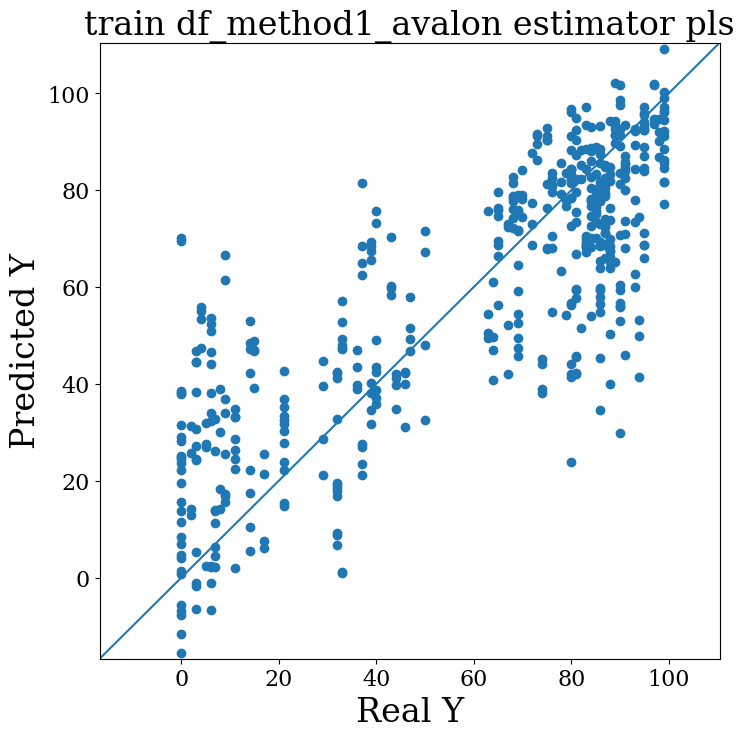

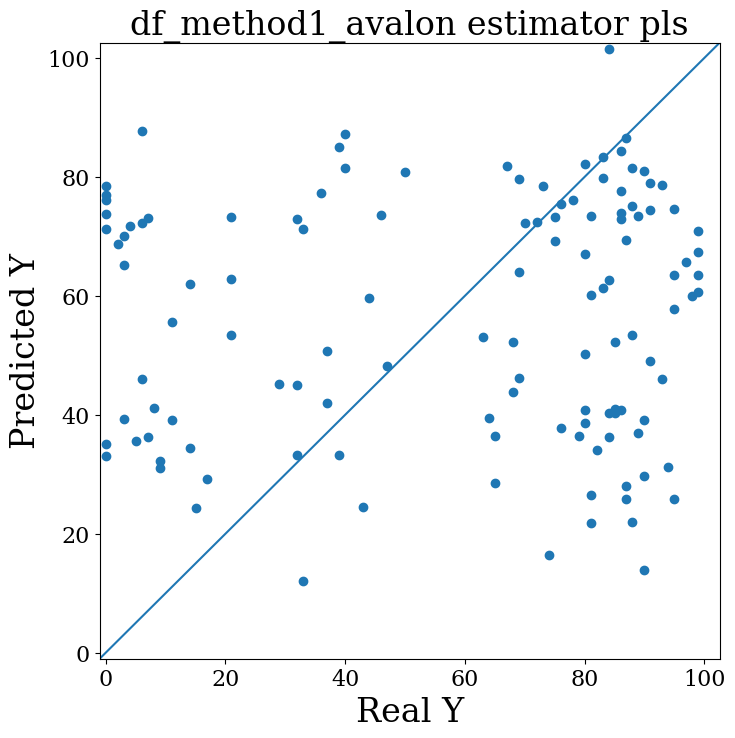

,df_method1_avalon
r2_train,0.659342
r2,-3.666827
rmse,37.631746
mae,32.197054


method: df_method1_maccs
PLSRegression(max_iter=5000, n_components=5, scale=False)
PLSRegression(max_iter=5000)
PLSRegression(max_iter=5000, n_components=3, scale=False)
PLSRegression(max_iter=5000)
PLSRegression(max_iter=5000, n_components=3, scale=False)


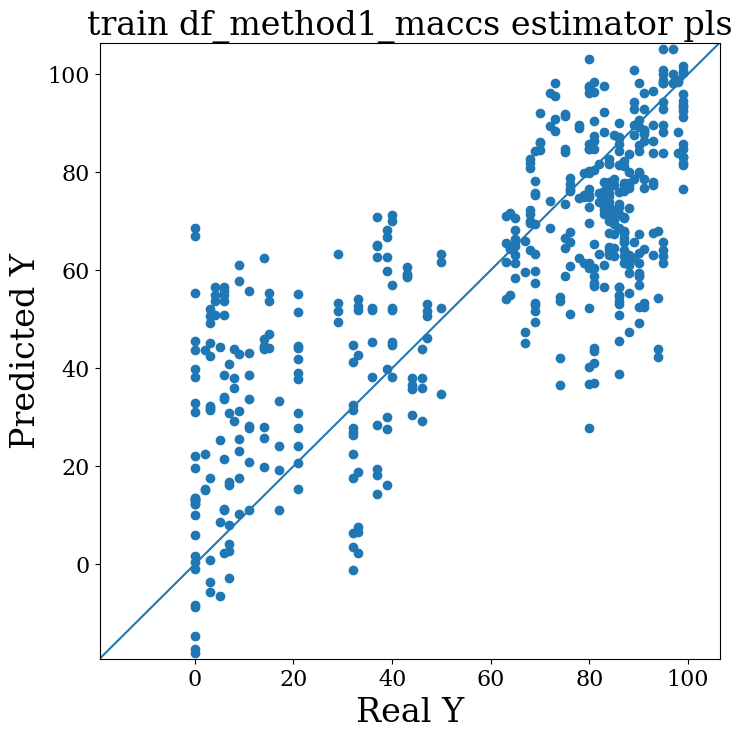

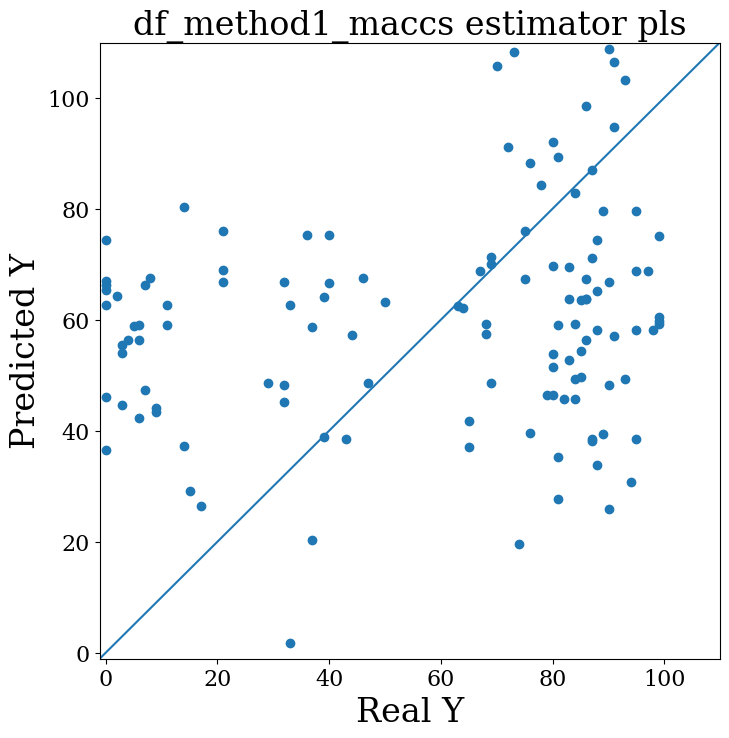

,df_method1_maccs
r2_train,0.589536
r2,-3.002138
rmse,34.846173
mae,30.566389


method: df_method1_minhash
PLSRegression(max_iter=5000, n_components=3, scale=False)
PLSRegression(max_iter=5000, n_components=3, scale=False)
PLSRegression(max_iter=5000, scale=False)
PLSRegression(max_iter=5000, n_components=5, scale=False)
PLSRegression(max_iter=5000, scale=False)


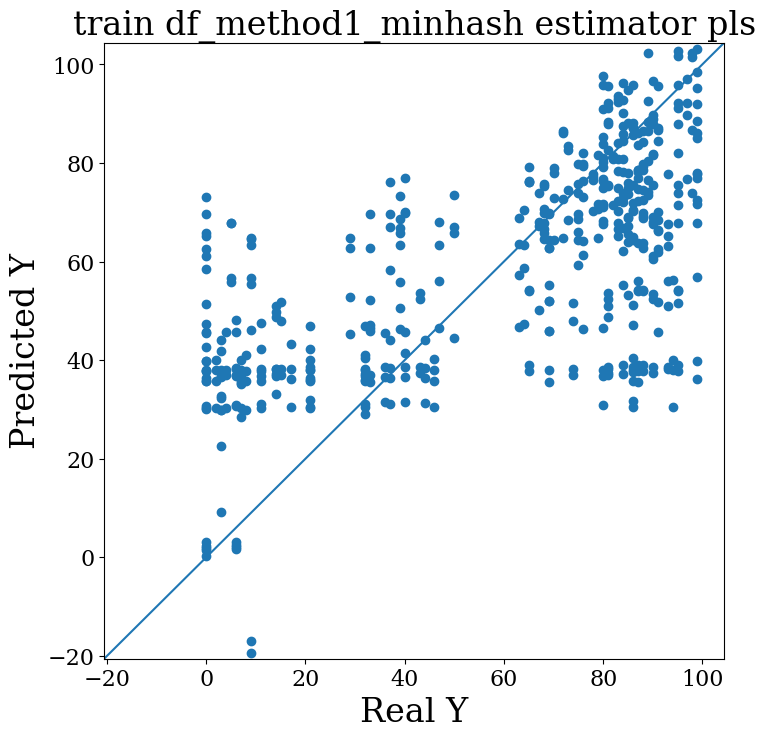

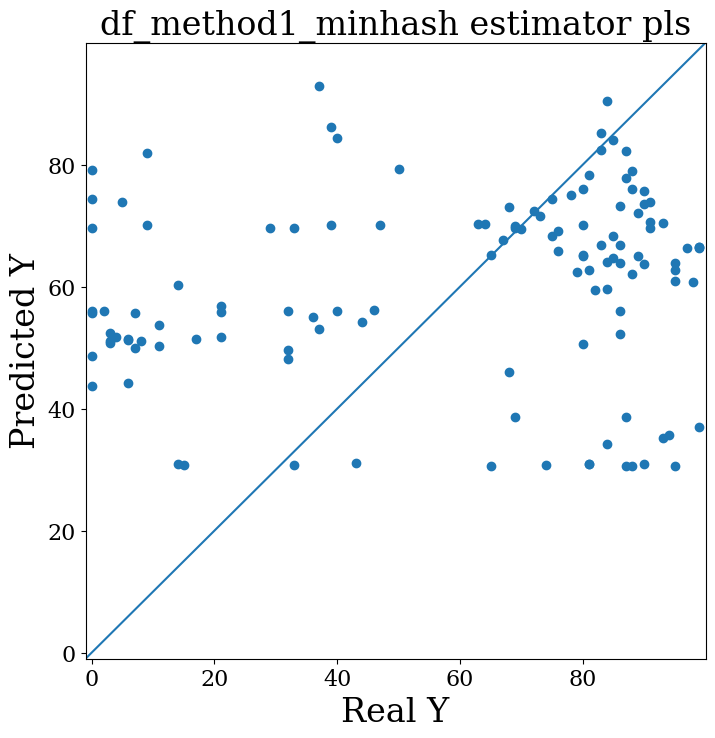

,df_method1_minhash
r2_train,0.400728
r2,-2.295638
rmse,34.537353
mae,28.827343


method: df_method1_morgan_feature
PLSRegression(max_iter=5000, n_components=5, scale=False)
PLSRegression(max_iter=5000, scale=False)
PLSRegression(max_iter=5000, n_components=3, scale=False)
PLSRegression(max_iter=5000, n_components=5, scale=False)
PLSRegression(max_iter=5000, n_components=3)


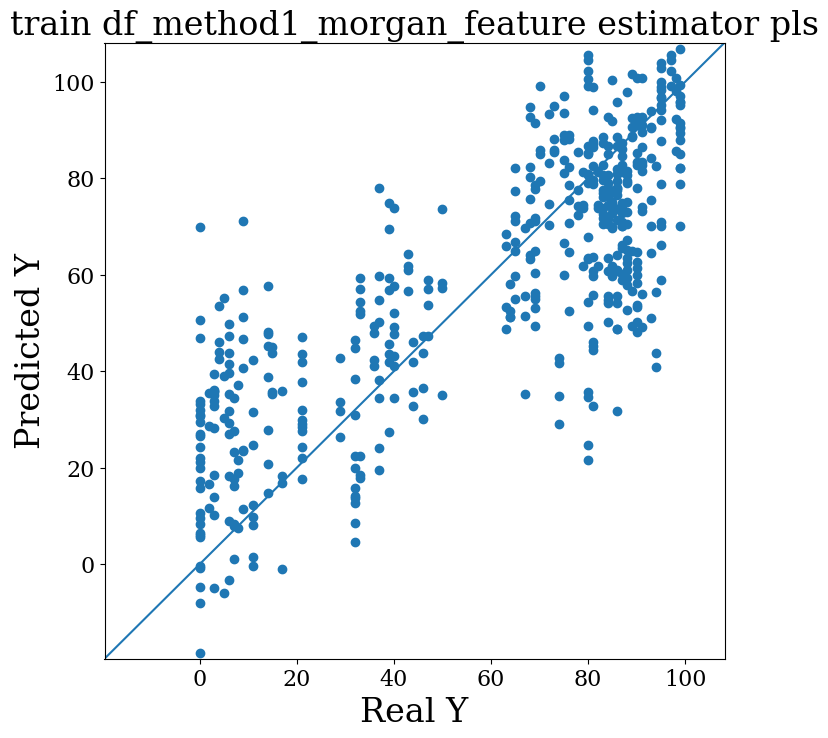

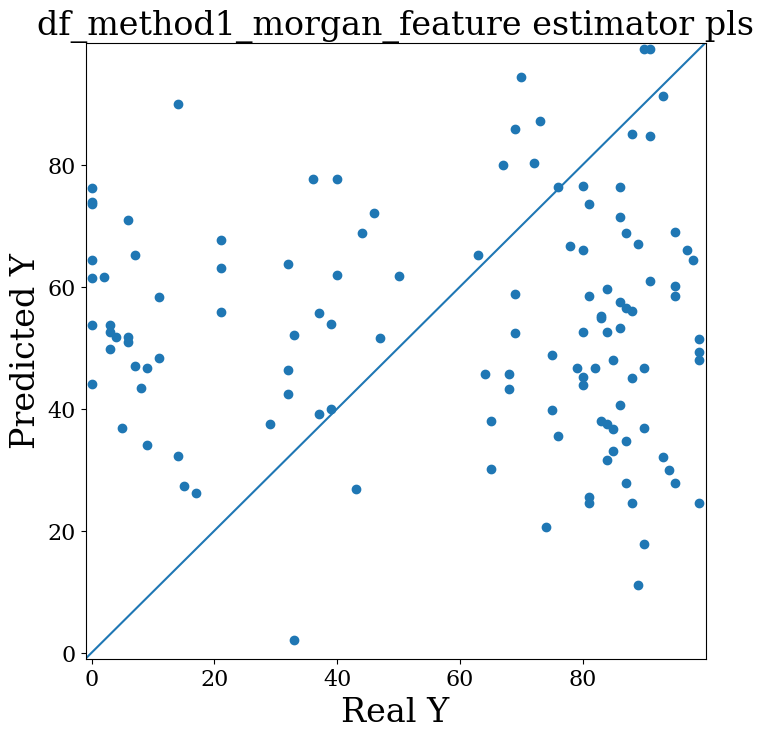

,df_method1_morgan_feature
r2_train,0.618724
r2,-4.573754
rmse,38.244731
mae,34.183469


method: df_method1_morgan
PLSRegression(max_iter=5000, n_components=6, scale=False)
PLSRegression(max_iter=5000)
PLSRegression(max_iter=5000, scale=False)
PLSRegression(max_iter=5000, scale=False)
PLSRegression(max_iter=5000, n_components=3)


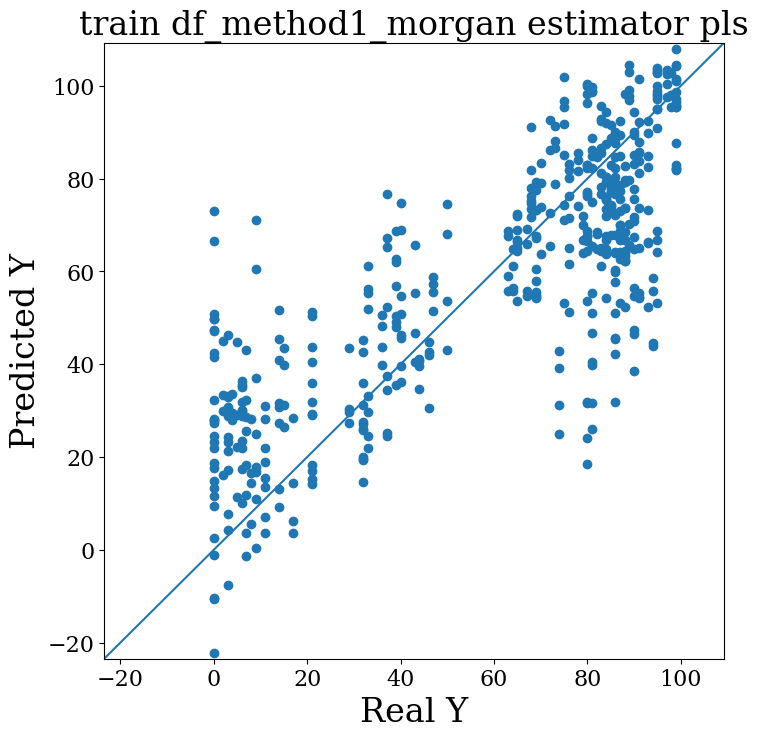

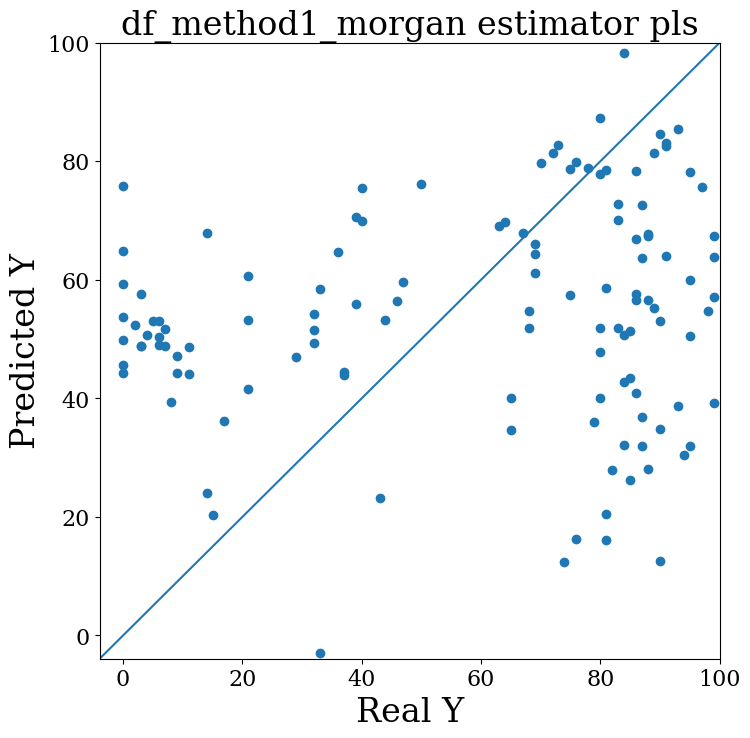

,df_method1_morgan
r2_train,0.627186
r2,-3.840398
rmse,35.106679
mae,30.871524


method: df_method1_rdkit
PLSRegression(max_iter=5000, n_components=6, scale=False)
PLSRegression(max_iter=5000, n_components=5)
PLSRegression(max_iter=5000, n_components=3, scale=False)
PLSRegression(max_iter=5000, n_components=4, scale=False)
PLSRegression(max_iter=5000, n_components=3, scale=False)


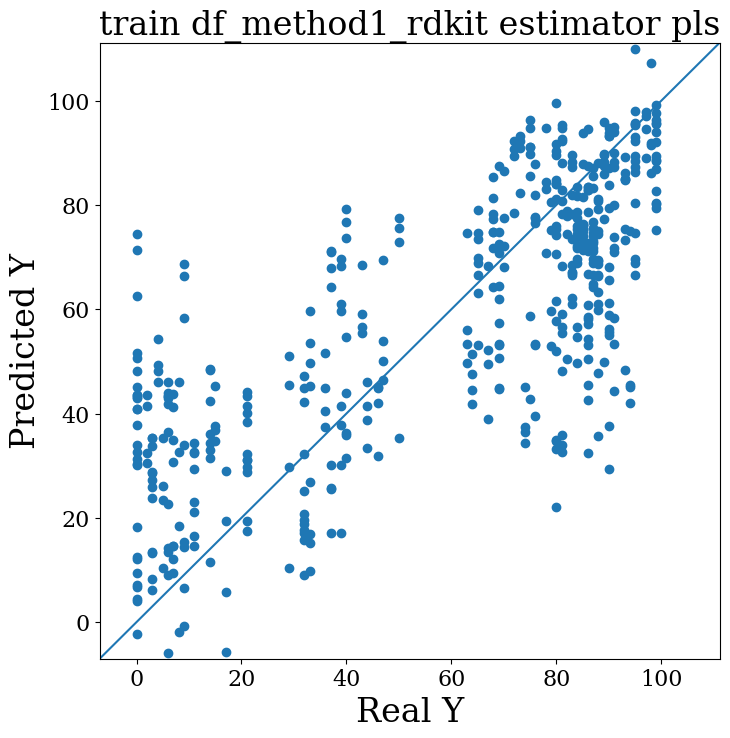

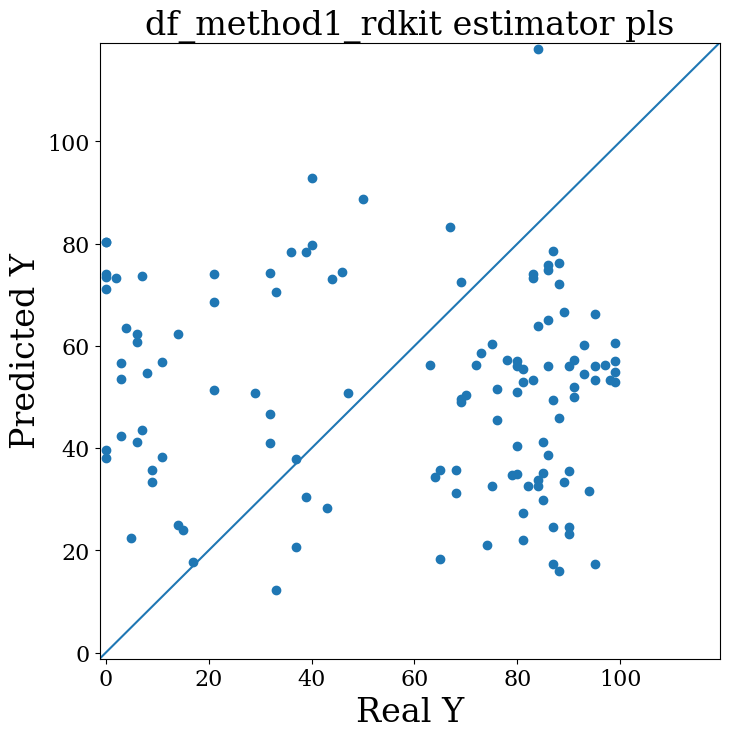

,df_method1_rdkit
r2_train,0.560954
r2,-4.663533
rmse,40.833994
mae,36.697176


In [62]:
for i in range(len(method1)):
    X = method1[i].drop(columns=['収率(%)'])
    y = method1[i]['収率(%)']
    excec_pls({method1_name[i]:[X,y]})
    

df_method1_avalon
RandomForestRegressor(max_depth=50, max_features='log2')
RandomForestRegressor(max_features='log2', n_estimators=10)
RandomForestRegressor(max_features='log2', n_estimators=10)
RandomForestRegressor(max_features='sqrt')
RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=200)


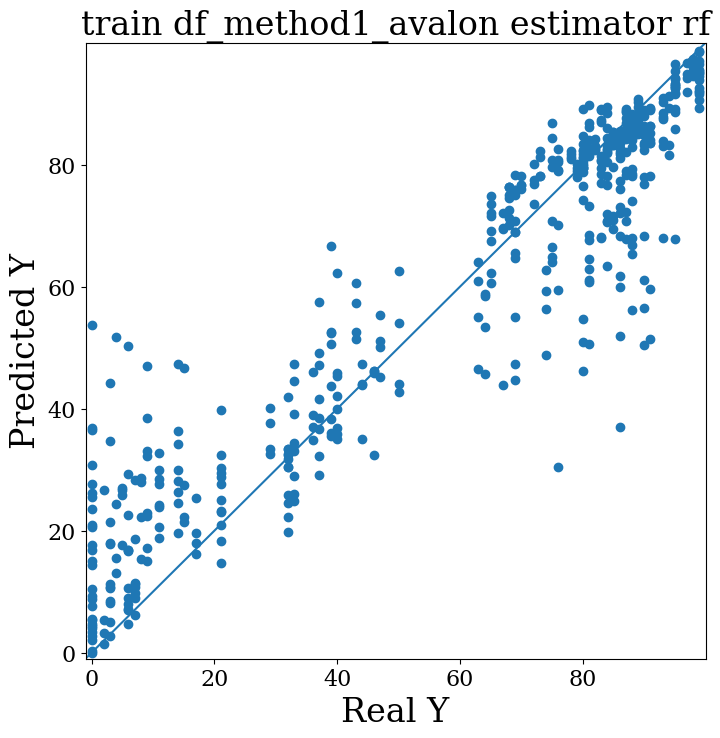

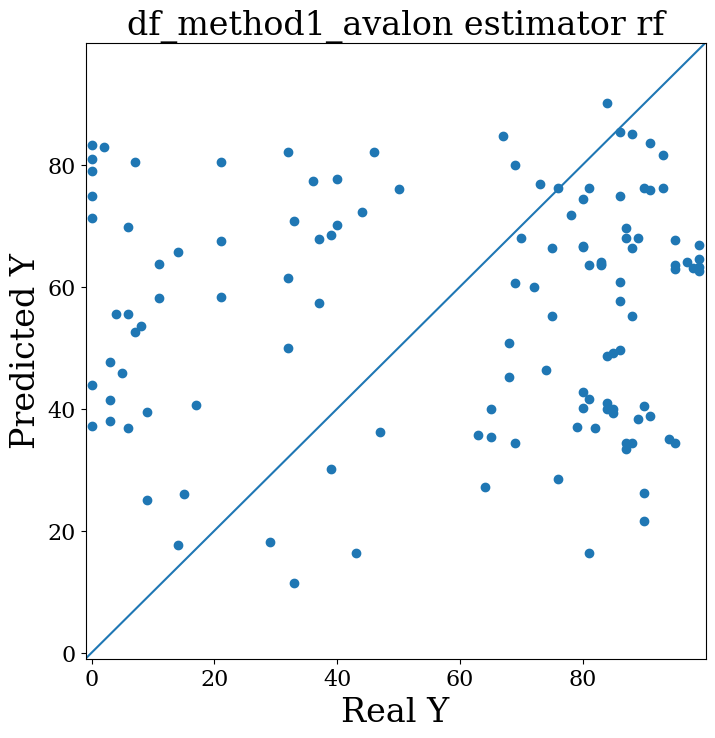

KeyError: 'best'

In [63]:
for i in range(len(method1)):
    X = method1[i].drop(columns=['収率(%)'])
    y = method1[i]['収率(%)']
    exec_rf({method1_name[i]:[X,y]})